# Packages

**installation**

In [5]:
!pip install --upgrade PyDrive
!pip install --upgrade keras
!pip install --upgrade google

Requirement already up-to-date: PyDrive in /Users/angeyannick/anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: PyYAML>=3.0 in /Users/angeyannick/anaconda3/lib/python3.6/site-packages (from PyDrive)
Requirement already up-to-date: google-api-python-client>=1.2 in /Users/angeyannick/anaconda3/lib/python3.6/site-packages (from PyDrive)
Requirement already up-to-date: oauth2client>=4.0.0 in /Users/angeyannick/anaconda3/lib/python3.6/site-packages (from PyDrive)
Requirement already up-to-date: six<2dev,>=1.6.1 in /Users/angeyannick/anaconda3/lib/python3.6/site-packages (from google-api-python-client>=1.2->PyDrive)
Requirement already up-to-date: uritemplate<4dev,>=3.0.0 in /Users/angeyannick/anaconda3/lib/python3.6/site-packages (from google-api-python-client>=1.2->PyDrive)
Requirement already up-to-date: httplib2<1dev,>=0.9.2 in /Users/angeyannick/anaconda3/lib/python3.6/site-packages (from google-api-python-client>=1.2->PyDrive)
Requirement already up-to-date: pyasn1>

**Importation**

In [2]:
import sys
import pytz
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from io import StringIO
from numpy import concatenate

from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from statsmodels.graphics.tsaplots import plot_acf

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

ModuleNotFoundError: No module named 'google.colab'

# Load data from google grive

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

meteo_train_loaded = {"id":"1x8Yp_JP6C1v33fyBqzpqMyJkd0aH1kuV", "data": None}

conso_train_loaded = {"id":"1-LdkZdni-EBxdr_CIOq-JYfkGrZz11Yg", "data": None}

meteo_prev_loaded = {"id":"1jMBVJn3imRhDgRNkDB6CNy1ATq5up9mI", "data": None}

files = [meteo_train_loaded, conso_train_loaded, meteo_prev_loaded]

for file in files:

  downloaded = drive.CreateFile({'id': file["id"]})

  downloaded_io = StringIO(downloaded.GetContentString())

  file["data"] = pd.read_csv(downloaded_io, sep=";")
 
meteo_train = meteo_train_loaded["data"]
conso_train = conso_train_loaded["data"]
meteo_prev = meteo_prev_loaded["data"]

**Quick inspection**

In [18]:
print("="*15, "meteo train", "="*15)
print(meteo_train.info())
print("="*15, "conso train", "="*15)
print(conso_train.info())

=============== meteo train ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 12 columns):
Date UTC           2920 non-null object
T¬∞ (C)            2856 non-null float64
P (hPa)            2856 non-null float64
HR (%)             2856 non-null float64
P.ros√©e (¬∞C)     2856 non-null float64
Visi (km)          2856 non-null float64
Vt. moy. (km/h)    2856 non-null float64
Vt. raf. (km/h)    2853 non-null float64
Vt. dir (¬∞)       2856 non-null float64
RR 3h (mm)         2584 non-null float64
Neige (cm)         969 non-null float64
Nebul. (octats)    2511 non-null float64
dtypes: float64(11), object(1)
memory usage: 273.8+ KB
None
=============== conso train ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
date         8760 non-null object
puissance    8760 non-null float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB
None


In [ ]:
meteo_train.rename(columns = {"Date UTC" : "date", "T¬∞ (C)" :"temperature", "P (hPa)": "p", "HR (%)" : "hr",
                                      "P.ros√©e (¬∞C)" : "p_rosv","Visi (km)": "visibility", "Vt. moy. (km/h)": "mean_wind",
                                      "Vt. raf. (km/h)": "gust_wind", "Vt. dir (¬∞)": "wind_dir","RR 3h (mm)": "rr", "Neige (cm)": "snow", 
                                      "Nebul. (octats)" : "nebul"}, inplace =True)

meteo_prev.rename(columns = {"Date UTC" : "date", "T¬∞ (C)" :"temperature", "P (hPa)": "p", "HR (%)" : "hr",
                                      "P.ros√©e (¬∞C)" : "p_rosv","Visi (km)": "visibility", "Vt. moy. (km/h)": "mean_wind",
                                      "Vt. raf. (km/h)": "gust_wind", "Vt. dir (¬∞)": "wind_dir","RR 3h (mm)": "rr", "Neige (cm)": "snow", 
                                      "Nebul. (octats)" : "nebul"}, inplace =True)


paris = pytz.timezone('Europe/Paris')

meteo_train["date"] = meteo_train["date"].str.replace("h", ":")
meteo_train["date"] = pd.to_datetime(meteo_train["date"], dayfirst = True, format = "%d/%m/%y %H:%M")
meteo_train.set_index("date", inplace = True)

meteo_prev["date"] = meteo_prev["date"].str.replace("h", ":")
meteo_prev["date"] = pd.to_datetime(meteo_prev["date"], dayfirst = True, format = "%d/%m/%y %H:%M")
meteo_prev.set_index("date", inplace = True)


conso_train["date"] = pd.to_datetime(conso_train["date"])
conso_train.set_index("date", inplace = True)
conso_train.index = conso_train.index.tz_localize(pytz.utc).tz_convert(paris)

In [20]:
print("="*15, "meteo train", "="*15)
print(meteo_train.info())
print("="*15, "conso train", "="*15)
print(conso_train.info())

=============== meteo train ===============
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2015-09-13 00:00:00 to 2016-09-12 21:00:00
Data columns (total 11 columns):
temperature    2856 non-null float64
p              2856 non-null float64
hr             2856 non-null float64
p_rosv         2856 non-null float64
visibility     2856 non-null float64
mean_wind      2856 non-null float64
gust_wind      2853 non-null float64
wind_dir       2856 non-null float64
rr             2584 non-null float64
snow           969 non-null float64
nebul          2511 non-null float64
dtypes: float64(11)
memory usage: 273.8 KB
None
=============== conso train ===============
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-09-13 00:59:59+02:00 to 2016-09-13 00:00:00+02:00
Data columns (total 1 columns):
puissance    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB
None


**Visualization**

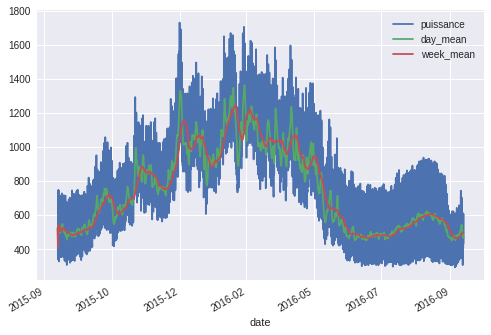

In [60]:
conso_train_day = conso_train["puissance"].rolling(window = "24H").agg(["mean"]).add_prefix("day_")

conso_train_week = conso_train["puissance"].rolling(window = "7D").agg(["mean"]).add_prefix("week_")

rolling = conso_train.join(conso_train_day)

rolling = rolling.join(conso_train_week)

rolling.plot()

plt.show()

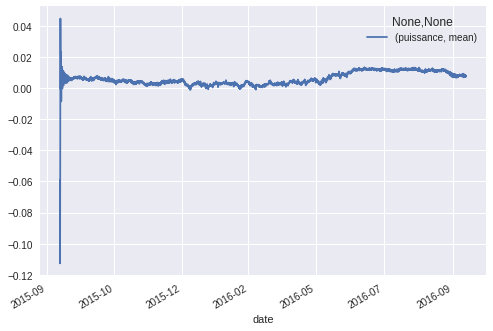

In [68]:
conso_train.pct_change().rolling(window = "7D").agg(["mean"]).plot()
plt.show()

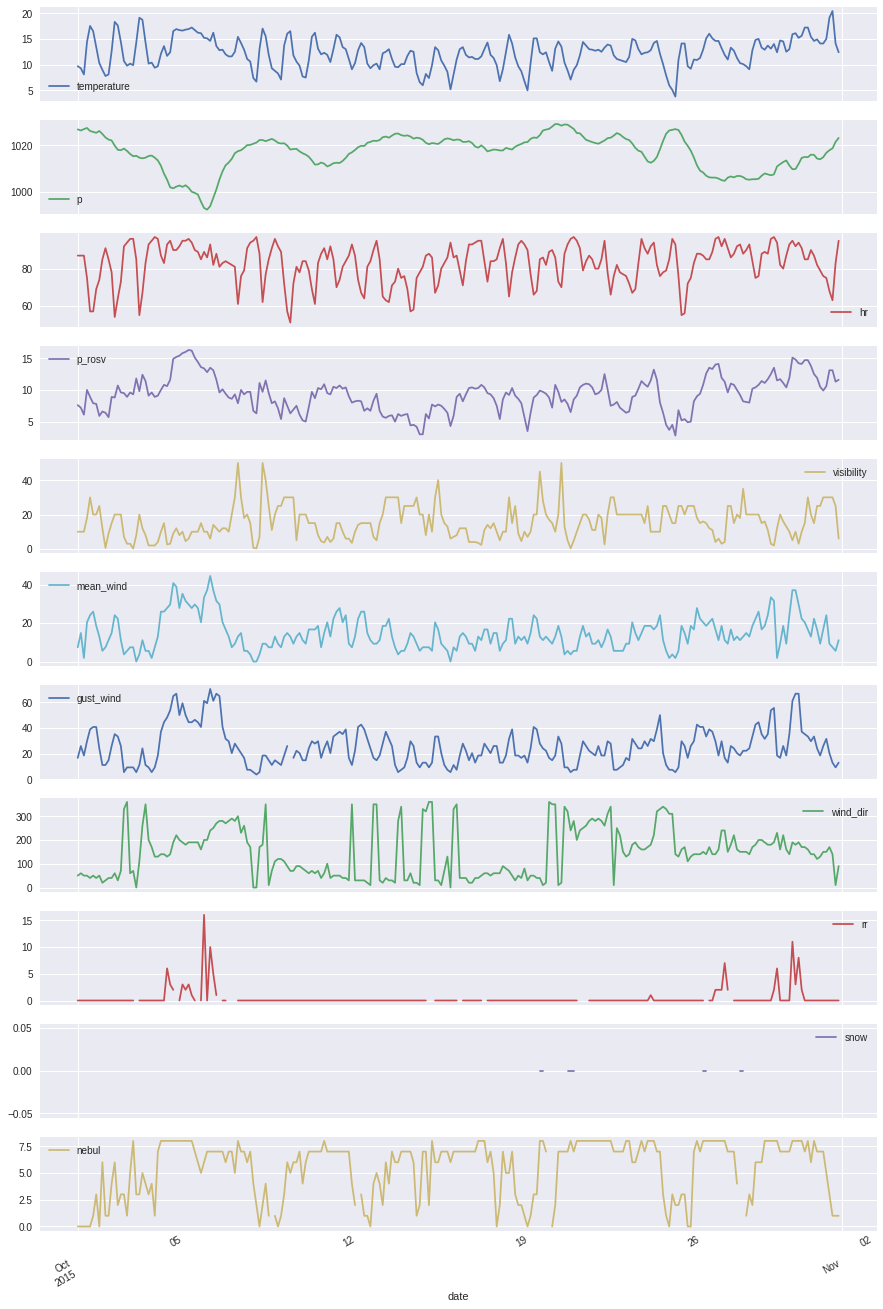

In [116]:
meteo_train["2015-10"].plot(subplots=True, figsize =(15, 25))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


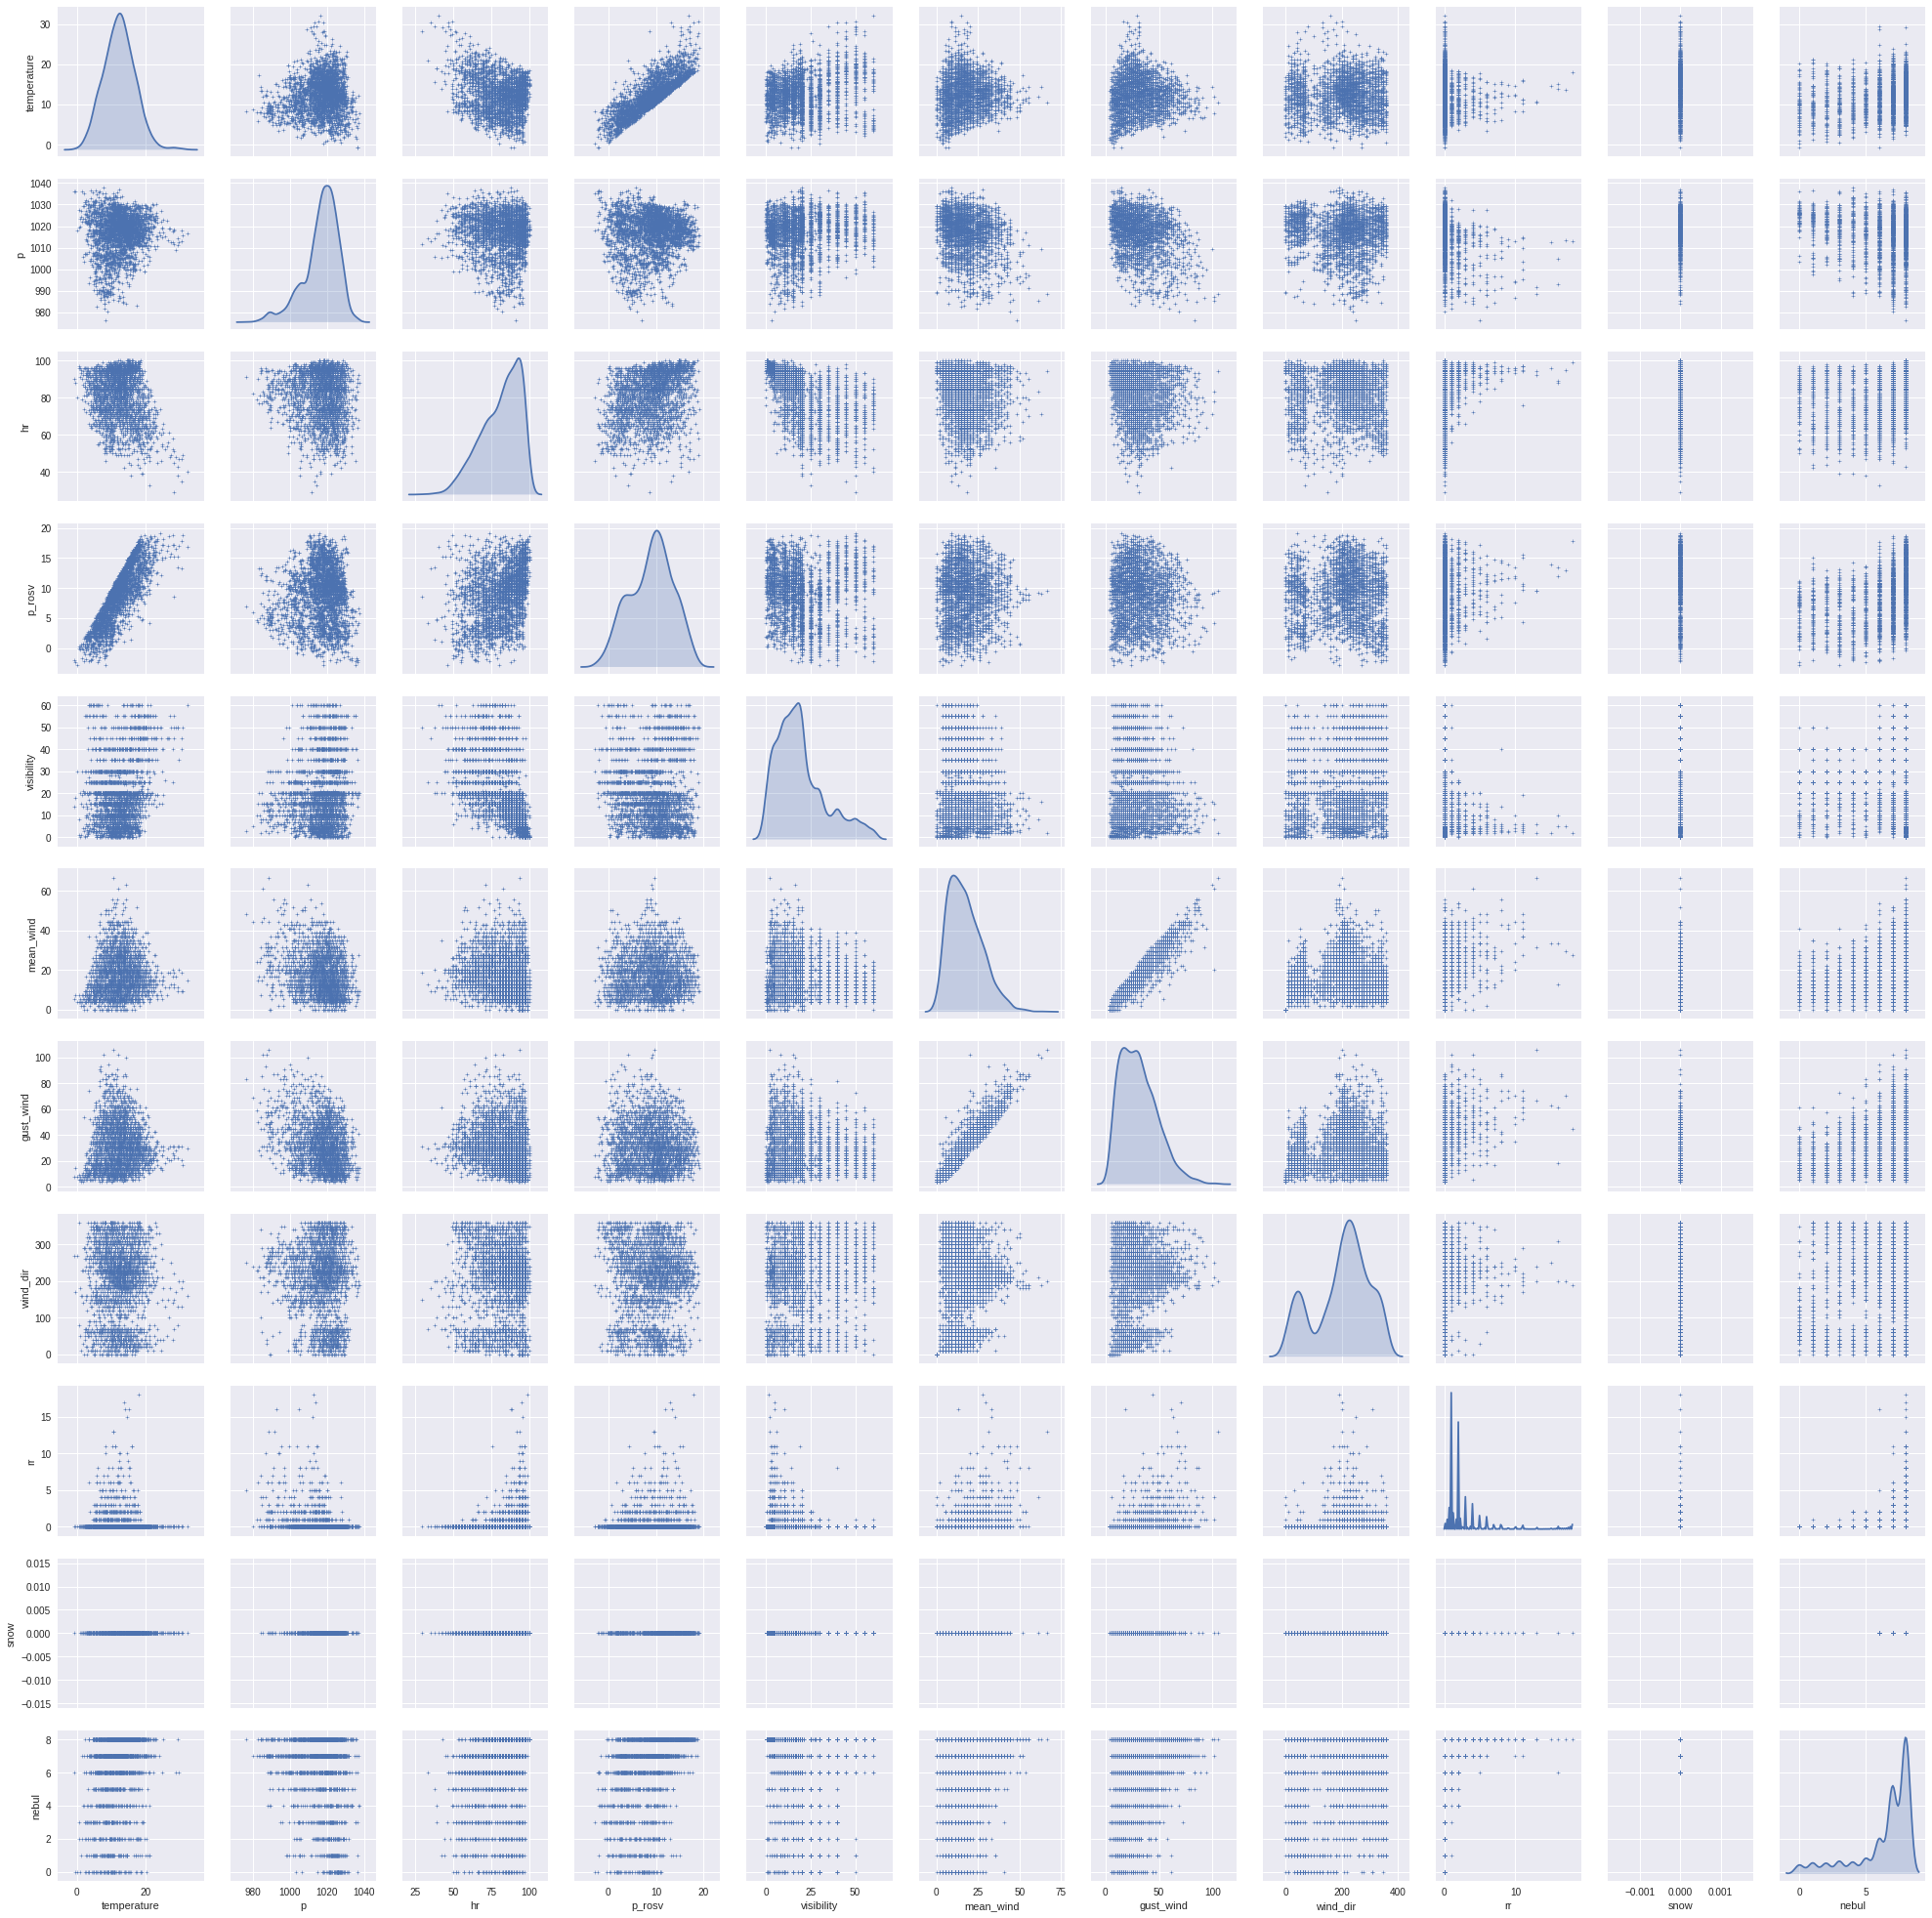

In [110]:
sns.pairplot(meteo_train.reset_index(drop = True), 
             diag_kind="kde",
             markers="+",
             plot_kws=dict(s=20, edgecolor="b", linewidth=0.5),
             diag_kws=dict(shade=True))

plt.show()

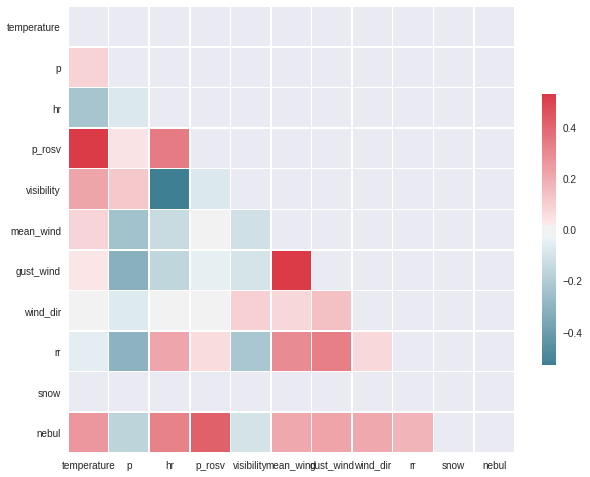

In [111]:
corr = meteo_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

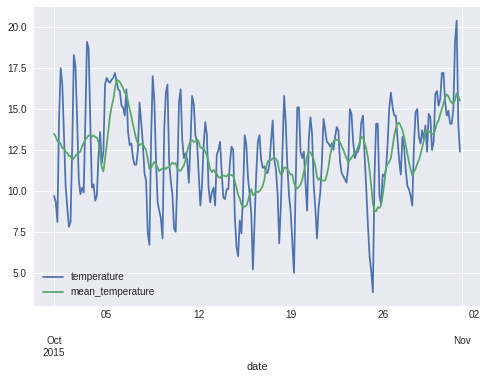

In [214]:
temperature_rolling = meteo_train[["temperature"]].rolling("24h").mean().add_prefix("mean_")

meteo_train[["temperature"]]["2015-10"].join(temperature_rolling).plot()
plt.show()

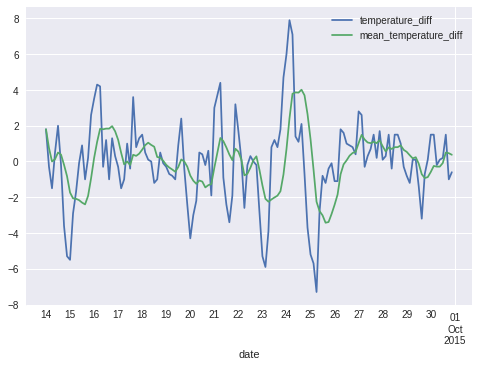

In [220]:
# seasonal difference
meteo_train_differenced = meteo_train[["temperature"]].diff(8)
meteo_train_differenced.columns = ["temperature_diff"]

# trim off the first year of empty data
meteo_train_differenced["temperature_diff"] = meteo_train_differenced["temperature_diff"][8:]
meteo_train_differenced_rolling = meteo_train_differenced[["temperature_diff"]].rolling("24h").mean().add_prefix("mean_")

# plot differenced dataset
meteo_train_differenced[8:]["2015-09"].join(meteo_train_differenced_rolling).plot()
plt.show()

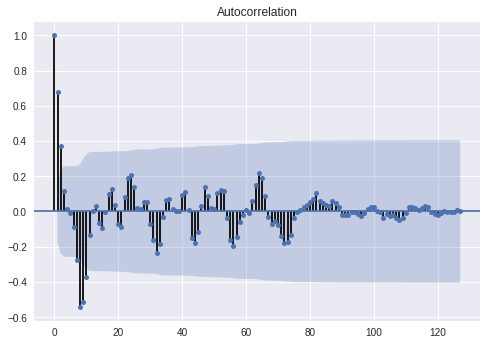

In [242]:
meteo_train_differenced = meteo_train_differenced[8:]

plot_acf(meteo_train_differenced["2015-09-12":"2015-09-30"])
plt.show()

In [265]:
# reframe as supervised learning
dataframe = pd.DataFrame()

for i in range(8,0,-1):
  dataframe['t-'+str(i)] = meteo_train_differenced["temperature_diff"].shift(i)
 
dataframe['t'] = meteo_train_differenced.values
  
print(dataframe.head(10))
dataframe = dataframe[8:]
print(dataframe.head(10))
# save to new file
#dataframe.to_csv('lags_1day_features.csv', index=False)

                     t-8  t-7  t-6  t-5  t-4  t-3  t-2  t-1    t
date                                                            
2015-09-15 00:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -5.5
2015-09-15 03:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN -5.5 -2.9
2015-09-15 06:00:00  NaN  NaN  NaN  NaN  NaN  NaN -5.5 -2.9 -1.7
2015-09-15 09:00:00  NaN  NaN  NaN  NaN  NaN -5.5 -2.9 -1.7 -0.1
2015-09-15 12:00:00  NaN  NaN  NaN  NaN -5.5 -2.9 -1.7 -0.1  0.9
2015-09-15 15:00:00  NaN  NaN  NaN -5.5 -2.9 -1.7 -0.1  0.9 -1.0
2015-09-15 18:00:00  NaN  NaN -5.5 -2.9 -1.7 -0.1  0.9 -1.0  0.2
2015-09-15 21:00:00  NaN -5.5 -2.9 -1.7 -0.1  0.9 -1.0  0.2  2.6
2015-09-16 00:00:00 -5.5 -2.9 -1.7 -0.1  0.9 -1.0  0.2  2.6  3.5
2015-09-16 03:00:00 -2.9 -1.7 -0.1  0.9 -1.0  0.2  2.6  3.5  4.3
                     t-8  t-7  t-6  t-5  t-4  t-3  t-2  t-1    t
date                                                            
2015-09-16 00:00:00 -5.5 -2.9 -1.7 -0.1  0.9 -1.0  0.2  2.6  3.5
2015-09-16 03:00:00 -2.9 

[0.09396631 0.05405857 0.04588608 0.04240513 0.04385153 0.04804627
 0.05876076 0.61302534]


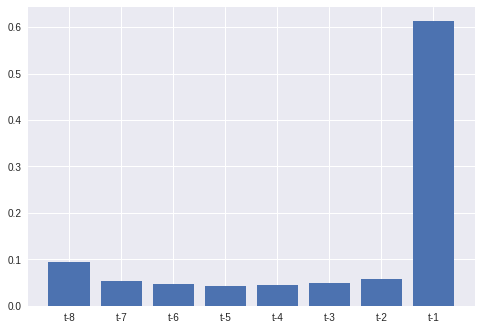

In [273]:
array = dataframe.dropna().values
# split into input and output
X = array[:,0:-1]

y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

# show importance scores
print(model.feature_importances_)

# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names)
plt.show()

Selected Features:
t-8
t-7
t-2
t-1


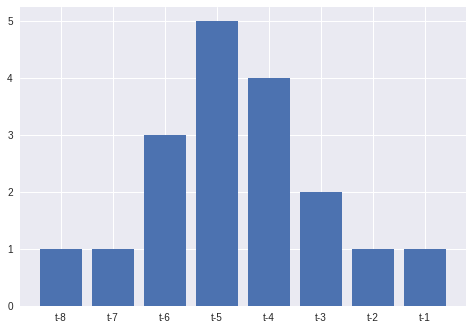

In [274]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# separate into input and output variables
array = dataframe.dropna().values
X = array[:,0:-1]
y = array[:,-1]

# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 4)
fit = rfe.fit(X, y)

# report selected features
print('Selected Features:')
names = dataframe.columns.values[0:-1]
for i in range(len(fit.support_)):
	if fit.support_[i]:
		print(names[i])
    
# plot feature rank
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [ ]:
meteo_train_2015 = meteo_train["2015"]
meteo_train_2016 = meteo_train["2016"]

conso_train_2015 = conso_train["2015"]
conso_train_2016 = conso_train["2016"]

In [225]:
meteo_train_2015_with_one = meteo_train_2015.append(meteo_train_2016.iloc[0, :])

meteo_train_2015_resampled = meteo_train_2015_with_one.resample("H").interpolate().iloc[1:-1]

print("2015 lenght match ?", len(meteo_train_2015_resampled) == len(conso_train_2015))

2015 lenght match ? True


In [226]:
meteo_train_2016_resampled = meteo_train_2016.resample("H").interpolate()

date_29_02_2016 = meteo_train_2016_resampled["2016-02-29"].index

meteo_train_2016_resampled.drop(date_29_02_2016, inplace=True)

conso_train_2016_adjusted = conso_train_2016.iloc[:-3]

print("2016 lenght match ?", len(meteo_train_2016_resampled) == len(conso_train_2016_adjusted))

2016 lenght match ? True


In [227]:
meteo_train_resampled = pd.concat([meteo_train_2015_resampled, meteo_train_2016_resampled])
meteo_train_resampled.drop("snow", axis = 1, inplace=True)
meteo_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8757 entries, 2015-09-13 01:00:00 to 2016-09-12 21:00:00
Data columns (total 10 columns):
temperature    8757 non-null float64
p              8757 non-null float64
hr             8757 non-null float64
p_rosv         8757 non-null float64
visibility     8757 non-null float64
mean_wind      8757 non-null float64
gust_wind      8757 non-null float64
wind_dir       8757 non-null float64
rr             8757 non-null float64
nebul          8757 non-null float64
dtypes: float64(10)
memory usage: 752.6 KB


In [228]:
conso_train_resampled = pd.concat([conso_train_2015, conso_train_2016_adjusted])

conso_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8757 entries, 2015-09-13 00:59:59+02:00 to 2016-09-12 21:00:00+02:00
Data columns (total 1 columns):
puissance    8757 non-null float64
dtypes: float64(1)
memory usage: 136.8 KB


             temperature         p        hr    p_rosv  visibility  mean_wind  \
temperature     1.000000  0.080676 -0.204051  0.843975    0.209041   0.063110   
p               0.080676  1.000000 -0.076594  0.034271    0.137671  -0.230256   
hr             -0.204051 -0.076594  1.000000  0.349030   -0.542927  -0.116113   
p_rosv          0.843975  0.034271  0.349030  1.000000   -0.086311   0.008341   
visibility      0.209041  0.137671 -0.542927 -0.086311    1.000000  -0.115321   
mean_wind       0.063110 -0.230256 -0.116113  0.008341   -0.115321   1.000000   
gust_wind       0.013968 -0.316606 -0.140551 -0.051121   -0.107835   0.946530   
wind_dir       -0.013888 -0.067292 -0.003072 -0.008409    0.106837   0.080675   
rr             -0.055656 -0.330070  0.216552  0.059316   -0.233409   0.304864   
nebul           0.287710 -0.141644  0.289594  0.437887   -0.068157   0.207688   
puissance      -0.625730 -0.157029 -0.112652 -0.657846    0.008892   0.268680   

             gust_wind  win

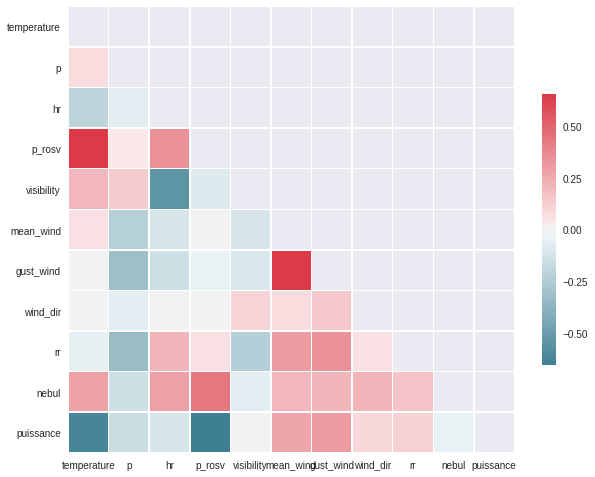

In [232]:
corr = meteo_train_resampled.reset_index(drop=True).join(conso_train_resampled.reset_index(drop=True)).corr()

print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

**Model**

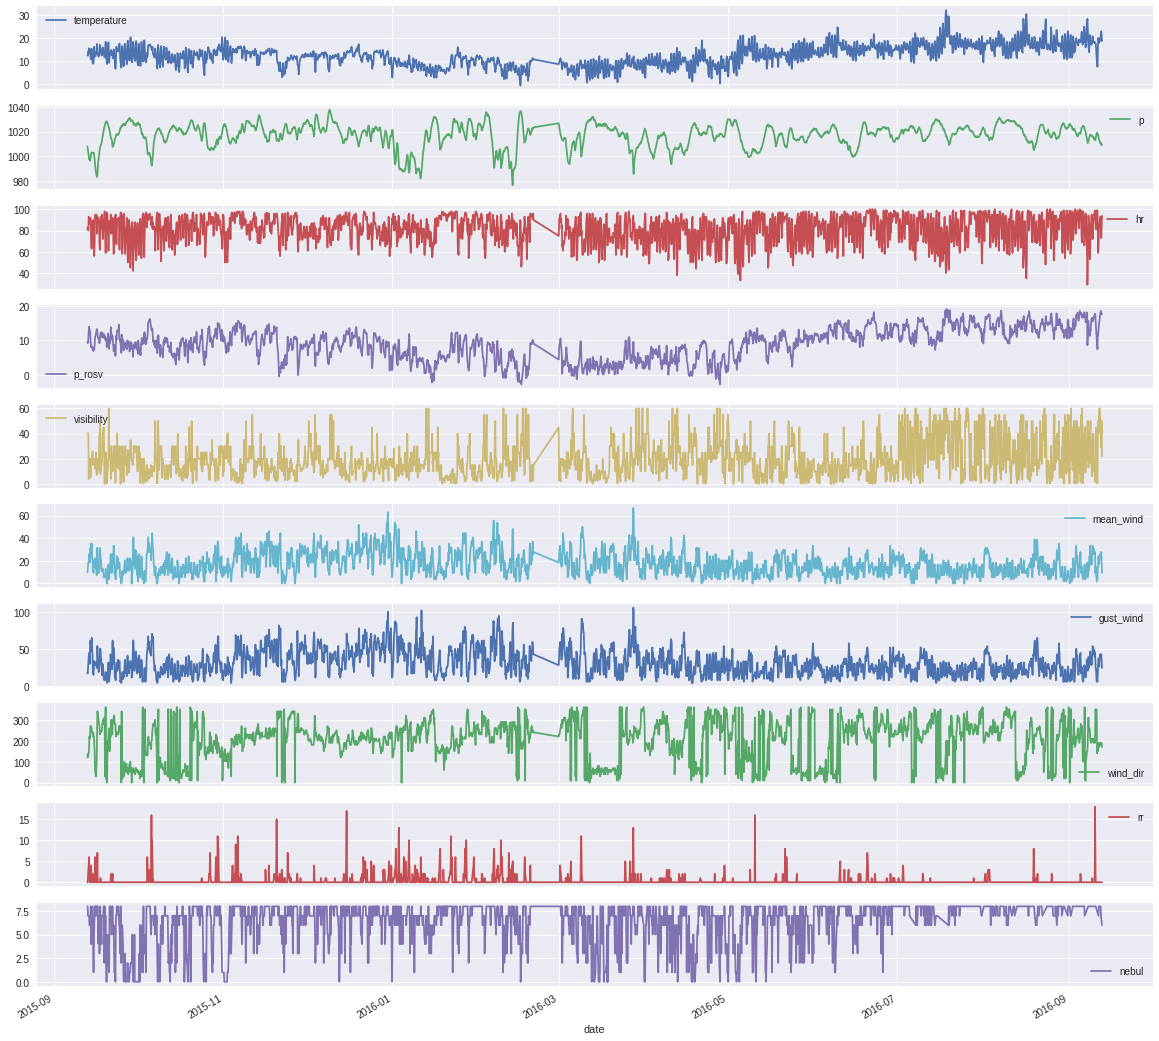

In [13]:
meteo_train_resampled.plot(subplots=True, figsize=(20, 20))

plt.show()

In [14]:
meteo_train_resampled.values

array([[  12.43333333, 1007.93333333,   81.66666667, ...,  133.33333333,
           0.        ,    8.        ],
       [  12.36666667, 1007.16666667,   82.33333333, ...,  126.66666667,
           0.        ,    8.        ],
       [  12.3       , 1006.4       ,   83.        , ...,  120.        ,
           0.        ,    8.        ],
       ...,
       [  20.1       , 1009.06666667,   86.        , ...,  183.33333333,
           0.        ,    6.22222222],
       [  19.4       , 1009.13333333,   90.        , ...,  176.66666667,
           0.        ,    6.11111111],
       [  18.7       , 1009.2       ,   94.        , ...,  170.        ,
           0.        ,    6.        ]])

In [33]:
# split into train and test sets

X = meteo_train_resampled.values
y = conso_train_resampled.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

n_train_hours = 355 * 24

X_train = X[:n_train_hours, :]
X_test = X[n_train_hours:, :]

y_train = y[:n_train_hours, :]
y_test = y[n_train_hours:, :]

y_train = y_train.flatten()
y_test = y_test.flatten()

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8520, 1, 10) (8520,) (237, 1, 10) (237,)


Train on 8520 samples, validate on 237 samples
Epoch 1/50
 - 9s - loss: 451.4952 - val_loss: 83.5405
Epoch 2/50
 - 8s - loss: 230.5648 - val_loss: 190.4822
Epoch 3/50
 - 8s - loss: 222.4669 - val_loss: 208.1663
Epoch 4/50
 - 8s - loss: 222.0694 - val_loss: 210.6812
Epoch 5/50
 - 8s - loss: 221.9084 - val_loss: 211.1927
Epoch 6/50
 - 8s - loss: 221.5646 - val_loss: 206.3691
Epoch 7/50
 - 8s - loss: 206.7394 - val_loss: 106.2142
Epoch 8/50
 - 8s - loss: 176.2948 - val_loss: 98.0617
Epoch 9/50
 - 8s - loss: 156.7695 - val_loss: 92.8757
Epoch 10/50
 - 8s - loss: 143.7484 - val_loss: 90.1667
Epoch 11/50
 - 8s - loss: 136.2798 - val_loss: 88.7411
Epoch 12/50
 - 8s - loss: 132.1308 - val_loss: 87.8892
Epoch 13/50
 - 8s - loss: 130.2291 - val_loss: 87.2096
Epoch 14/50
 - 8s - loss: 128.4499 - val_loss: 86.5011
Epoch 15/50
 - 8s - loss: 127.3587 - val_loss: 86.6671
Epoch 16/50
 - 8s - loss: 126.4996 - val_loss: 86.0835
Epoch 17/50
 - 8s - loss: 126.0196 - val_loss: 85.7042
Epoch 18/50
 - 8s - l

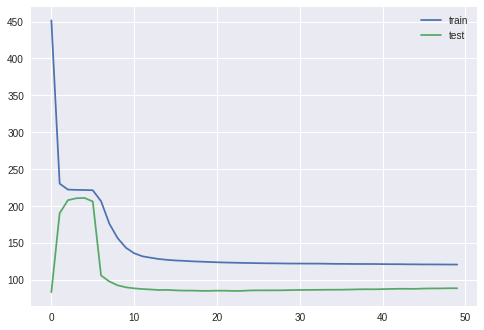

In [34]:
# design network
model = Sequential()
model.add(LSTM(800, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
y_test_pred = model.predict(X_test)

In [38]:
mean_absolute_error(y_test_pred, y_test)

88.86423300356027

In [43]:
np.sqrt(mean_squared_error(y_test_pred, y_test))

109.37021718066642